In [1]:
%load_ext autoreload
%autoreload 2

# Orthogonality of all known sRNAs to all known mRNAs, recorded as transcription units, in E. coli

Previously, we looked at how the sRNAs documented in the RNAInter database interact with all of the mRNAs in the RNAInter database, in other words the activity of the sRNAs on the mRNAs known to be regulated by sRNAs in general. Now we will look at how orthogonal the sRNAs are to any mRNA present in E. coli. The transcriptional units from the EcoCyc database represent all known mRNAs and the sRNAs are pulled from both the RNAInter and EcoCyc databases. 

# Imports

In [2]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import re
import logging 

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.IntaRNA.bin.copomus.IntaRNA import IntaRNA
from synbio_morpher.srv.parameter_prediction.simulator import process_raw_stdout
from synbio_morpher.utils.circuit.common.config_setup import retrieve_default_args, load_simulator_kwargs
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.misc.type_handling import get_nth_elements, flatten_listlike

from subprocess import Popen, PIPE, run
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax



In [3]:
fn_tus = os.path.join('..', 'data', 'sRNA', 'EcoCyc', 'EcoCyc_TUs.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
d_tus = pd.read_csv(fn_tus)
d_merged = pd.read_csv(fn_merged)
d_inter = pd.read_csv(fn_inter)
try:
    d_tus = d_tus.drop(columns=['Unnamed: 0'])
    d_merged = d_merged.drop(columns=['Unnamed: 0'])
    d_inter = d_inter.drop(columns=['Unnamed: 0'])
except:
    pass

In [4]:
d_tus['Sequence - Length'] = d_tus['Sequence - DNA sequence'].str.len()
d_merged.head()

Name             ID Category Symbol  \
0  acnA    NCBI:946724     mRNA   acnA   
1  acrZ    NCBI:945365     mRNA   acrZ   
2  arcZ   NCBI:2847690     sRNA   arcZ   
3  argR    NCBI:947861     mRNA   argR   
4  arrS  NCBI:11115378     sRNA   arrS   

                                            Sequence  Database Alias  \
0  ATTCGGAACGAGGCCTGAAGCAGTGTCGCCGTCCCTCTGCCTTGCA...  RNAInter   NaN   
1  ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...  RNAInter   NaN   
2  CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...  RNAInter   NaN   
3  GACAATGGCGATAGTATGGCGGTTGTTTCTTTCCCATCTCTACTCA...  RNAInter   NaN   
4  CTCTCCCTCTCTTTCTCTCTTCTCCGCGGCGATACGATCCGAGATG...  RNAInter   NaN   

  Genomic position Strand                                    Sequence before  
0              NaN    NaN  tcttctgggccgaactcctctggatcattactcactgatccttgac...  
1              NaN    NaN  ACTTACTACTGTCTTCGGGGGGTCCGAGGTTTCTGGGGGGTCGTAC...  
2              NaN    NaN  CTCATGTTGACCGCTTGTTTAGCAGCTTCAAGGAAGCTGAAGGGCA...  
3              NaN    NaN  aacaacatcaatttgataacaattaatttacttttaagcagaattt...  
4              NaN    NaN  CTCTCCCTCTCTTTCTCTCTTCTCCGCGGCGATACGATCCGAGATG...

In [5]:
print(len(d_tus))
nn = np.sum(np.arange(1, len(d_tus)+1)) + len(d_tus)
print('Expected number of species: ', nn)
print('Expected number of circuits: ', len(d_merged))
d_tus.head()

3698
Expected number of species:  6843149
Expected number of circuits:  590


Common-Name Transcription-Units  \
0        ygdG           TU0-13740   
1       ahpCF           TU0-14761   
2         fur             TU00121   
3  ymdAB-clsC           TU0-42664   
4      ydeTSR           TU0-13294   

                             Sequence - DNA sequence Regulated-By   Regulator  \
0  GTGGCTGTTCATTTGCTTATTGTCGATGCACTGAATCTTATTCGTC...          NaN         NaN   
1  GTTGTTGCATTTGTAAGGGCAACACCTCAGCCTGCAGGCAGGCACT...          NaN         NaN   
2  ATTATCTCAAGAGCAAATTCTGTCACTTCTTCTAATGAAGTGAACC...          NaN         NaN   
3  CCGGACGATCGGGTGAAAATAGTTGTTACTGTTTCTGATGGACAGT...   REG0-16016  CPLX0-3930   
4  ATGAGTGGTTACACCGTCAAGCCTCCTACCGGAGACACCAATGAGC...          NaN         NaN   

   Sequence - Length  
0                756  
1               2626  
2                599  
3               2576  
4               2209

In [6]:
d_merged['Category'].value_counts()

mRNA       429
sRNA       151
pseudo       5
Protein      5
Name: Category, dtype: int64

In [7]:
pattern = r'\s*\([^)]*\)'
for i in [1, 2]:
    d_inter[f'Binding position {i}'] = list(map(lambda raw: flatten_listlike(
        [[[int(re.sub(pattern, '', bp)) for bp in bps.split('..')]
          for bps in re.sub(pattern, '', par).split('; ')] for par in raw if par.split('..')[0].strip('-').isnumeric()]), d_inter[f'Binding position {i}'].apply(str).str.split("'")))

In [8]:
# srnas = dict(list(d_merged[d_merged['Category'].isin(['sRNA'])][['Name', 'Sequence']].to_numpy()))


srnas = {}
filt_srna1 = d_inter['Category 1'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA'])
filt_srna2 = d_inter['Category 2'].isin(['sRNA', 'trans-encoded antisense RNA', 'protein binding small RNA']) & (~d_inter['Category 1'].isin(['Protein']))
for i in [1, 2]:
    filt = filt_srna1 if i == 1 else filt_srna2
    for s in d_inter[f'Interactor {i}'].unique():
        seq = d_inter[d_inter[f'Interactor {i}'] == s][f'Sequence {i}'].iloc[0]
        offset = d_inter[d_inter[f'Interactor {i}'] == s][f'Binding position {i}'].iloc[0]
        if offset:
            offset = np.min(offset)
            if offset < 0: 
                seq = d_inter[d_inter[f'Interactor {i}'] == s][f'Sequence before {i}'].iloc[0] + seq
        if s in d_inter[d_inter[f'Category {i}'] == 'mRNA'][f'Interactor {i}'].unique():
            # mrnas[s] = seq.replace('T', 'U').replace('t', 'u')
            pass
        elif s in d_inter[filt][f'Interactor {i}'].unique():
            srnas[s] = seq.replace('T', 'U').replace('t', 'u')
            
            
            
mrnas = dict(list(d_tus[['Common-Name', 'Sequence - DNA sequence']].to_numpy()))
mrnas.update(dict(list(d_merged[d_merged['Category'] == 'mRNA'][['Name', 'Sequence']].to_numpy())))

for s, seq in mrnas.items():
    for i in [1, 2]:
        if (s not in d_merged['Name'].to_list()) or (s not in d_inter[f'Interactor {i}'].to_list()):
            continue
        offset = d_inter[d_inter[f'Interactor {i}'] == s][f'Binding position {i}'].iloc[0]
        if offset:
            offset = np.min(offset)
            if offset < 0: 
                seq = d_inter[d_inter[f'Interactor {i}'] == s][f'Sequence before {i}'].iloc[0] + seq
        mrnas[s] = seq
len(srnas)


            

42

In [25]:
len(srnas) * len(mrnas)

135786

In [11]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data": {},
    "system_type": "RNA",
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            # "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "outcsvcols": "id1, id2, E, E_norm, subseqDB, Pu1, Pu2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
}
data_writer = None
config, data_writer = script_preamble(config, data_writer)
default_args = retrieve_default_args()
simulator_kwargs = load_simulator_kwargs(default_args, config)
config['interaction_simulator']['simulator_kwargs'] = simulator_kwargs


In [8]:
config['interaction_simulator']['simulator_kwargs']['threads'] = 8

# Simulate

In [13]:
def simulate_IntaRNA_local(fn_query: str,
                           fn_targets: str,
                           sim_kwargs={}):
    # fn_query = data_writer.output(data=query, out_type='fasta', out_name='query', byseq=True, return_path=True)
    sim_kwargs['query'] = fn_query
    sim_kwargs['target'] = fn_targets

    def run(query: str, target: str, qidxpos0: int, tidxpos0: int, outcsvcols: str, threads: int, n: int = 1,
            param_file: str = '', extra_params: list = [], raw_stdout: bool = False):
        p = Popen(['IntaRNA', '-q', query, '-t', target,
                   '--outMode=C', f'--outcsvcols={outcsvcols}',
                   f'--qIdxPos0={qidxpos0}',
                   f'--tIdxPos0={tidxpos0}',
                   f'--outNumber={n}',
                   f'--threads={threads}', param_file]
                  + extra_params, stdout=PIPE, stderr=PIPE, universal_newlines=True)
        stdout, stderr = p.communicate()
        return process_raw_stdout(stdout)

    return run(**sim_kwargs)


fn_query = data_writer.output(
    data=srnas, out_type='fasta', out_name='query', byseq=True, return_path=True)
fn_targets = data_writer.output(
    data=mrnas, out_type='fasta', out_name='target', byseq=True, return_path=True)
sim_data = {}
# for s, sseq in srnas.items():
# sim_data[s] = {}
t = datetime.now()

sim_data = simulate_IntaRNA_local(fn_query=fn_query,
                                  fn_targets=fn_targets,
                                  sim_kwargs=config['interaction_simulator']['simulator_kwargs'])
logging.warning('Finished ', s, ' in ',
                (datetime.now() - t).total_seconds(), ' s')

data_writer.output(data=sim_data, out_type='json',
                   out_name='inter_data_raw', overwrite=True)

# Load simulation

In [10]:
# sim_data_l = load_json_as_dict('data/06_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
sim_data_l = load_json_as_dict('data/06_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
sim_data_l2 = load_json_as_dict('./data/06_orthogonality_mRNA_all/2024_01_04_105915/inter_data_raw.json')
            
default_vals = {
    'id1': '', 'id2': '', 'E': 0.0, 'E_norm': 0.0, 'bpList': '', 'hybridDPfull': '', 'seedPu1': '', 'seedPu2': '', 'seedStart1': '', 'seedStart2': '', 'seedEnd1': '', 'seedEnd2': '', 'subseqDB': '', 'Pu1': 0.0, 'Pu2': 0.0
}
for s, v in sim_data_l.items():
    for m in sim_data_l[s]:
        if m in sim_data_l2[s]:
            sim_data_l[s][m].update(sim_data_l2[s][m])
            
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        for d in diffs:
            sim_data_l[s][d] = default_vals
            
            

In [11]:
sim_data_l = {k: v for k, v in sim_data_l.items() if k in srnas.keys()}

In [27]:
# sim_data_l['6S RNA']['C0293']

In [18]:
len(sim_data_l.keys())

66

In [33]:
srna_cols = list(map(lambda x: ' '.join(x.split(' ')[-2:]).replace('RNA ', '').replace('antitoxin ', ''), sim_data_l.keys()))

In [34]:
energies = pd.DataFrame(data=np.array([[float(vv['E']) for vv in v.values()] for v in sim_data_l.values()]).T,
                        columns=srna_cols, index=list(list(sim_data_l.values())[0].keys()))

In [36]:
def remove_numerical_characters(input_string):
    # Use regular expression to remove numerical characters
    result_string = re.sub(r'\d', '', input_string)
    return result_string

k1 = list(sim_data_l.keys())[0]
k2 = list(sim_data_l[k1].keys())[0]
if 'bpList' in sim_data_l[k1][k2].keys():
    bplists = pd.DataFrame(data=np.array([[vv['bpList'] for vv in v.values()] for v in sim_data_l.values()]).T,
                           columns=srna_cols, index=list(list(sim_data_l.values())[0].keys()))
    binding_site_total_length = pd.DataFrame(columns=bplists.columns)
    binding_site_groups = pd.DataFrame(columns=bplists.columns)
    for s in bplists.columns:
        fbs = jax.tree_util.tree_map(
            lambda bb: string_to_tuple_list(bb), bplists[s].to_list())
        first = get_nth_elements(fbs, empty_replacement=[])
        bs = list(map(count_monotonic_group_lengths, first))
        binding_site_total_length[s] = list(map(sum, bs))
        binding_site_groups[s] = list(map(len, bs))
    binding_site_total_length.set_index(pd.Index(sim_data_l[k1].keys()), inplace=True)
    binding_site_groups.set_index(pd.Index(sim_data_l[k1].keys()), inplace=True)

# DON'T USE SUBSEQ TO DETERMINE BINDING SITE LENGTH
elif 'subseqDB' in sim_data_l[k1][k2].keys():
    binding_site_total_length = pd.DataFrame(data=np.array([[len(remove_numerical_characters(vv['subseqDB'].split('&')[0])) for vv in v.values()] for v in sim_data_l.values()]).T,
                                             columns=srna_cols, index=list(sim_data_l[k1].keys()))

## Visualise

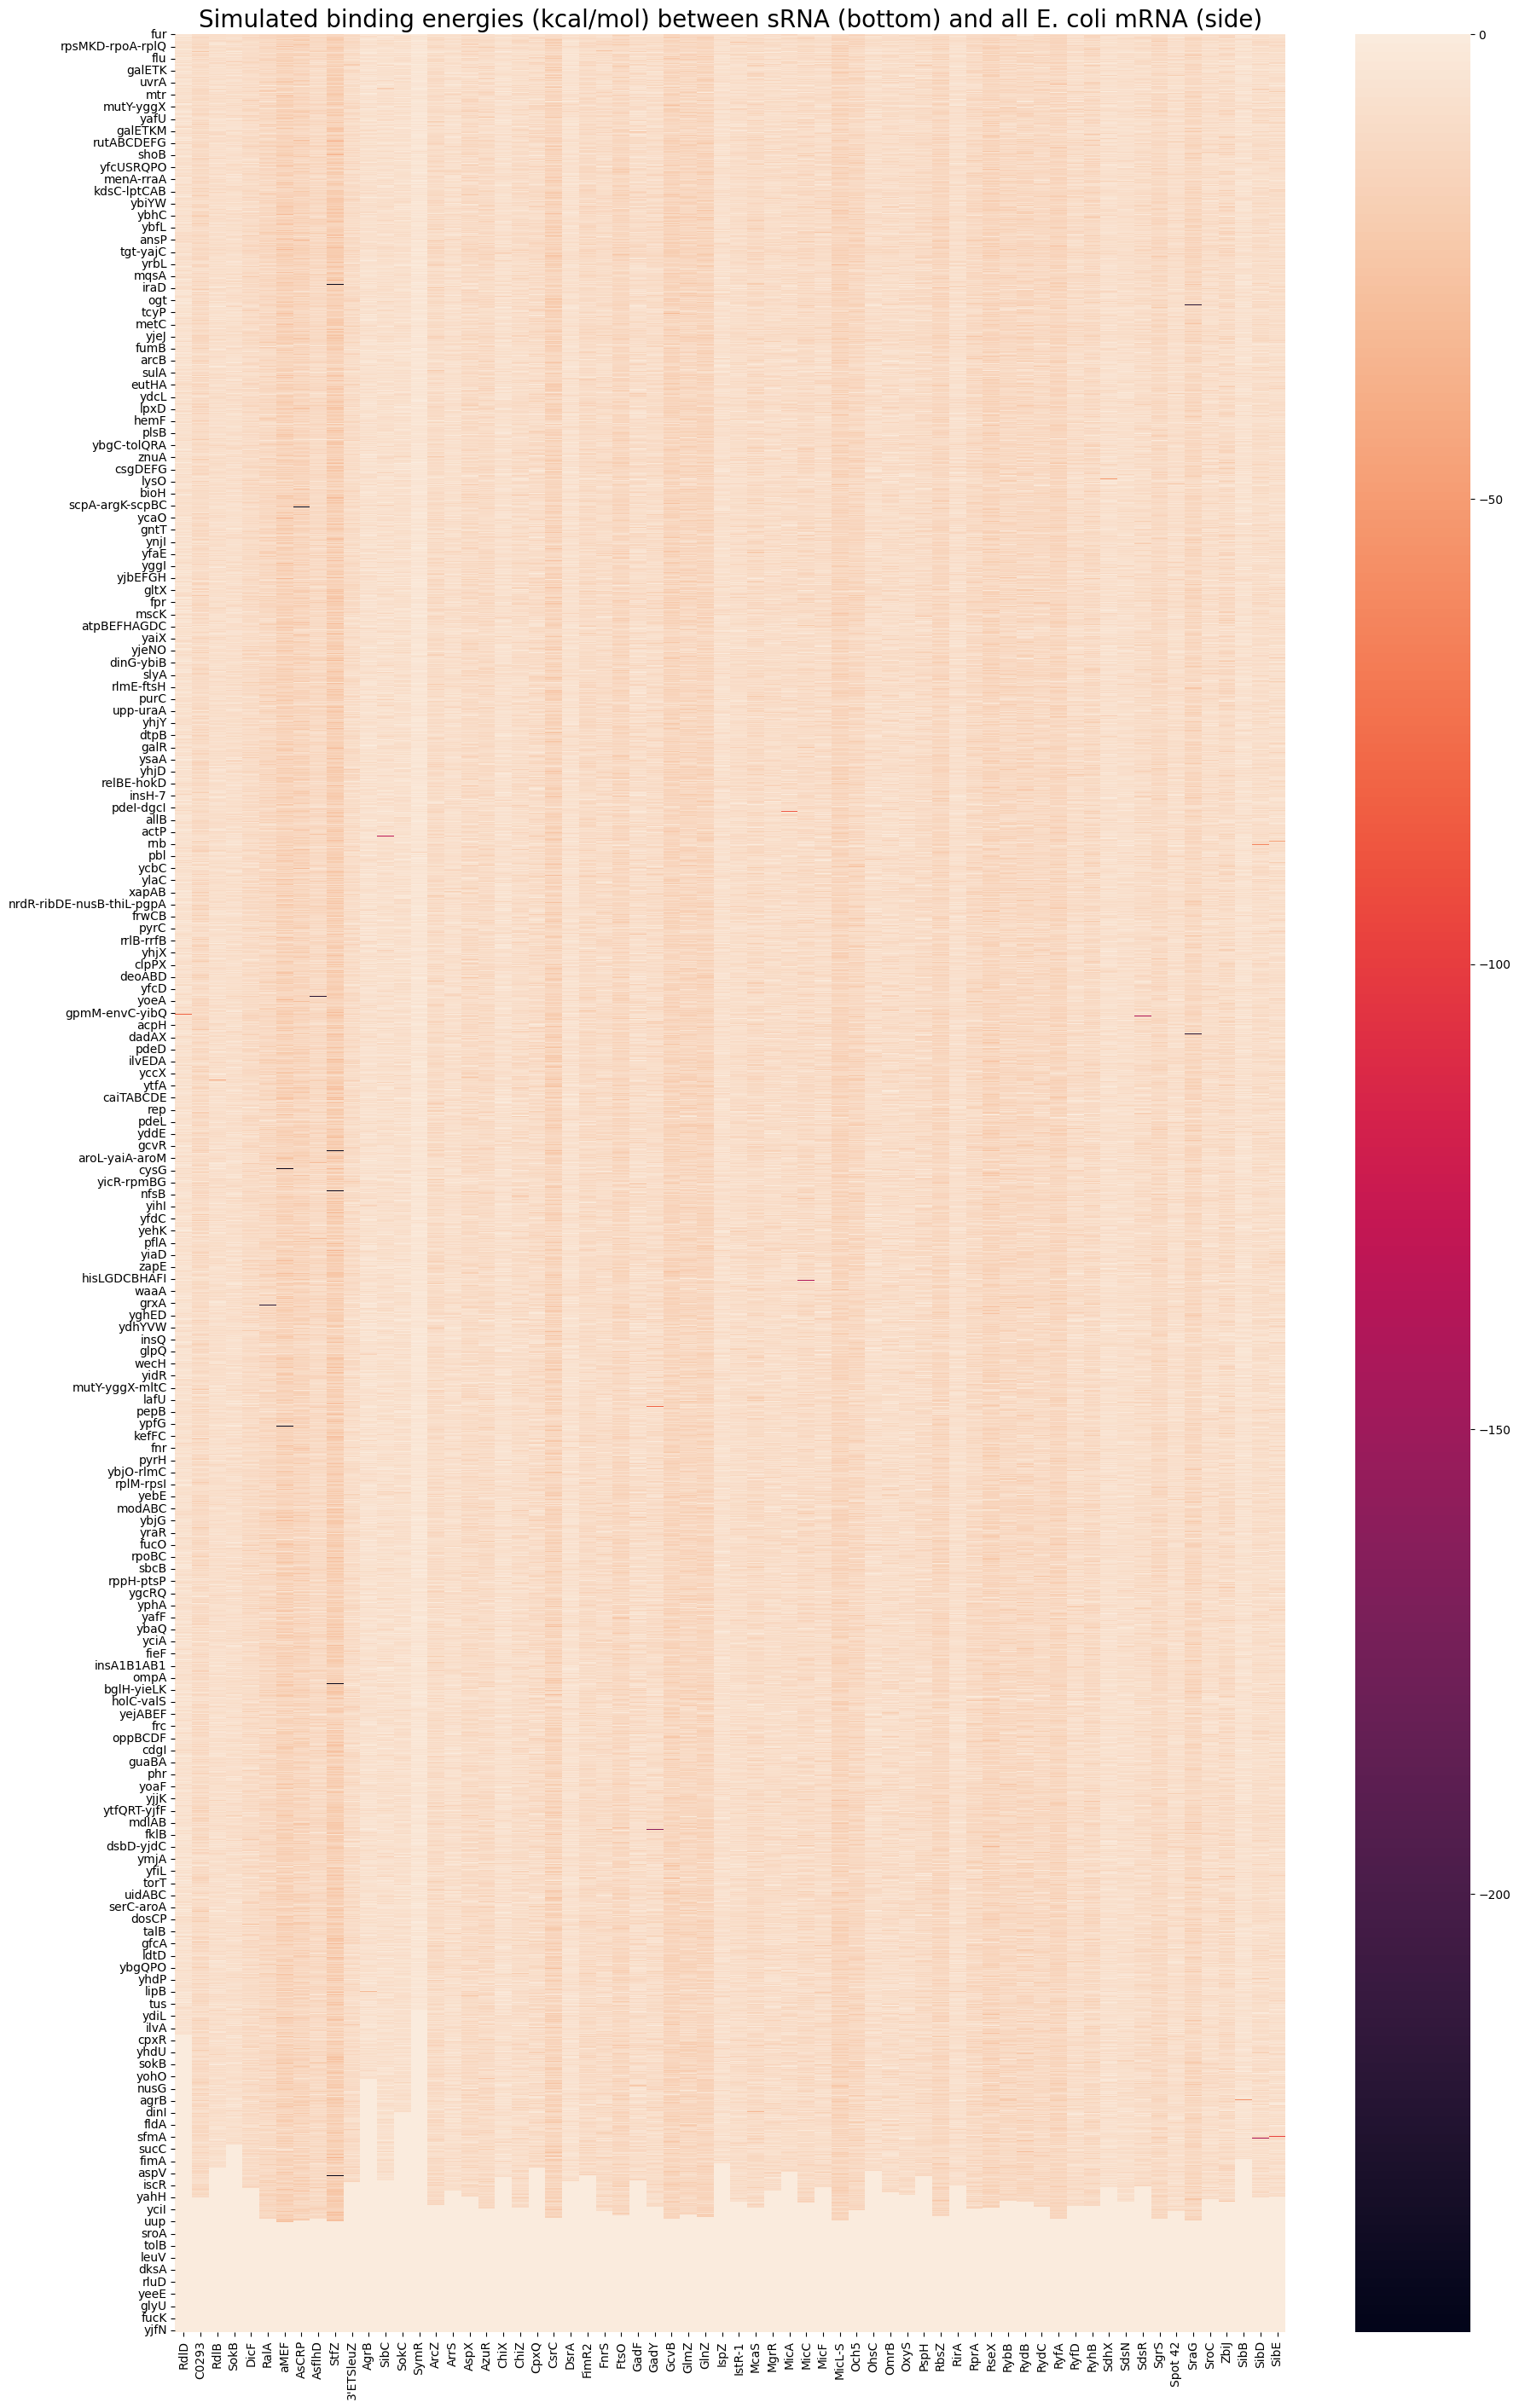

In [37]:
fig = plt.figure(figsize=(21, 35))

sns.heatmap(energies) # Spectral, cubehelix, vlag, icefire
plt.title('Simulated binding energies (kcal/mol) between sRNA (bottom) and all E. coli mRNA (side)', fontsize=20)

plt.savefig('data/figs/mRNA_all_energies.jpg')

### Binding site total length

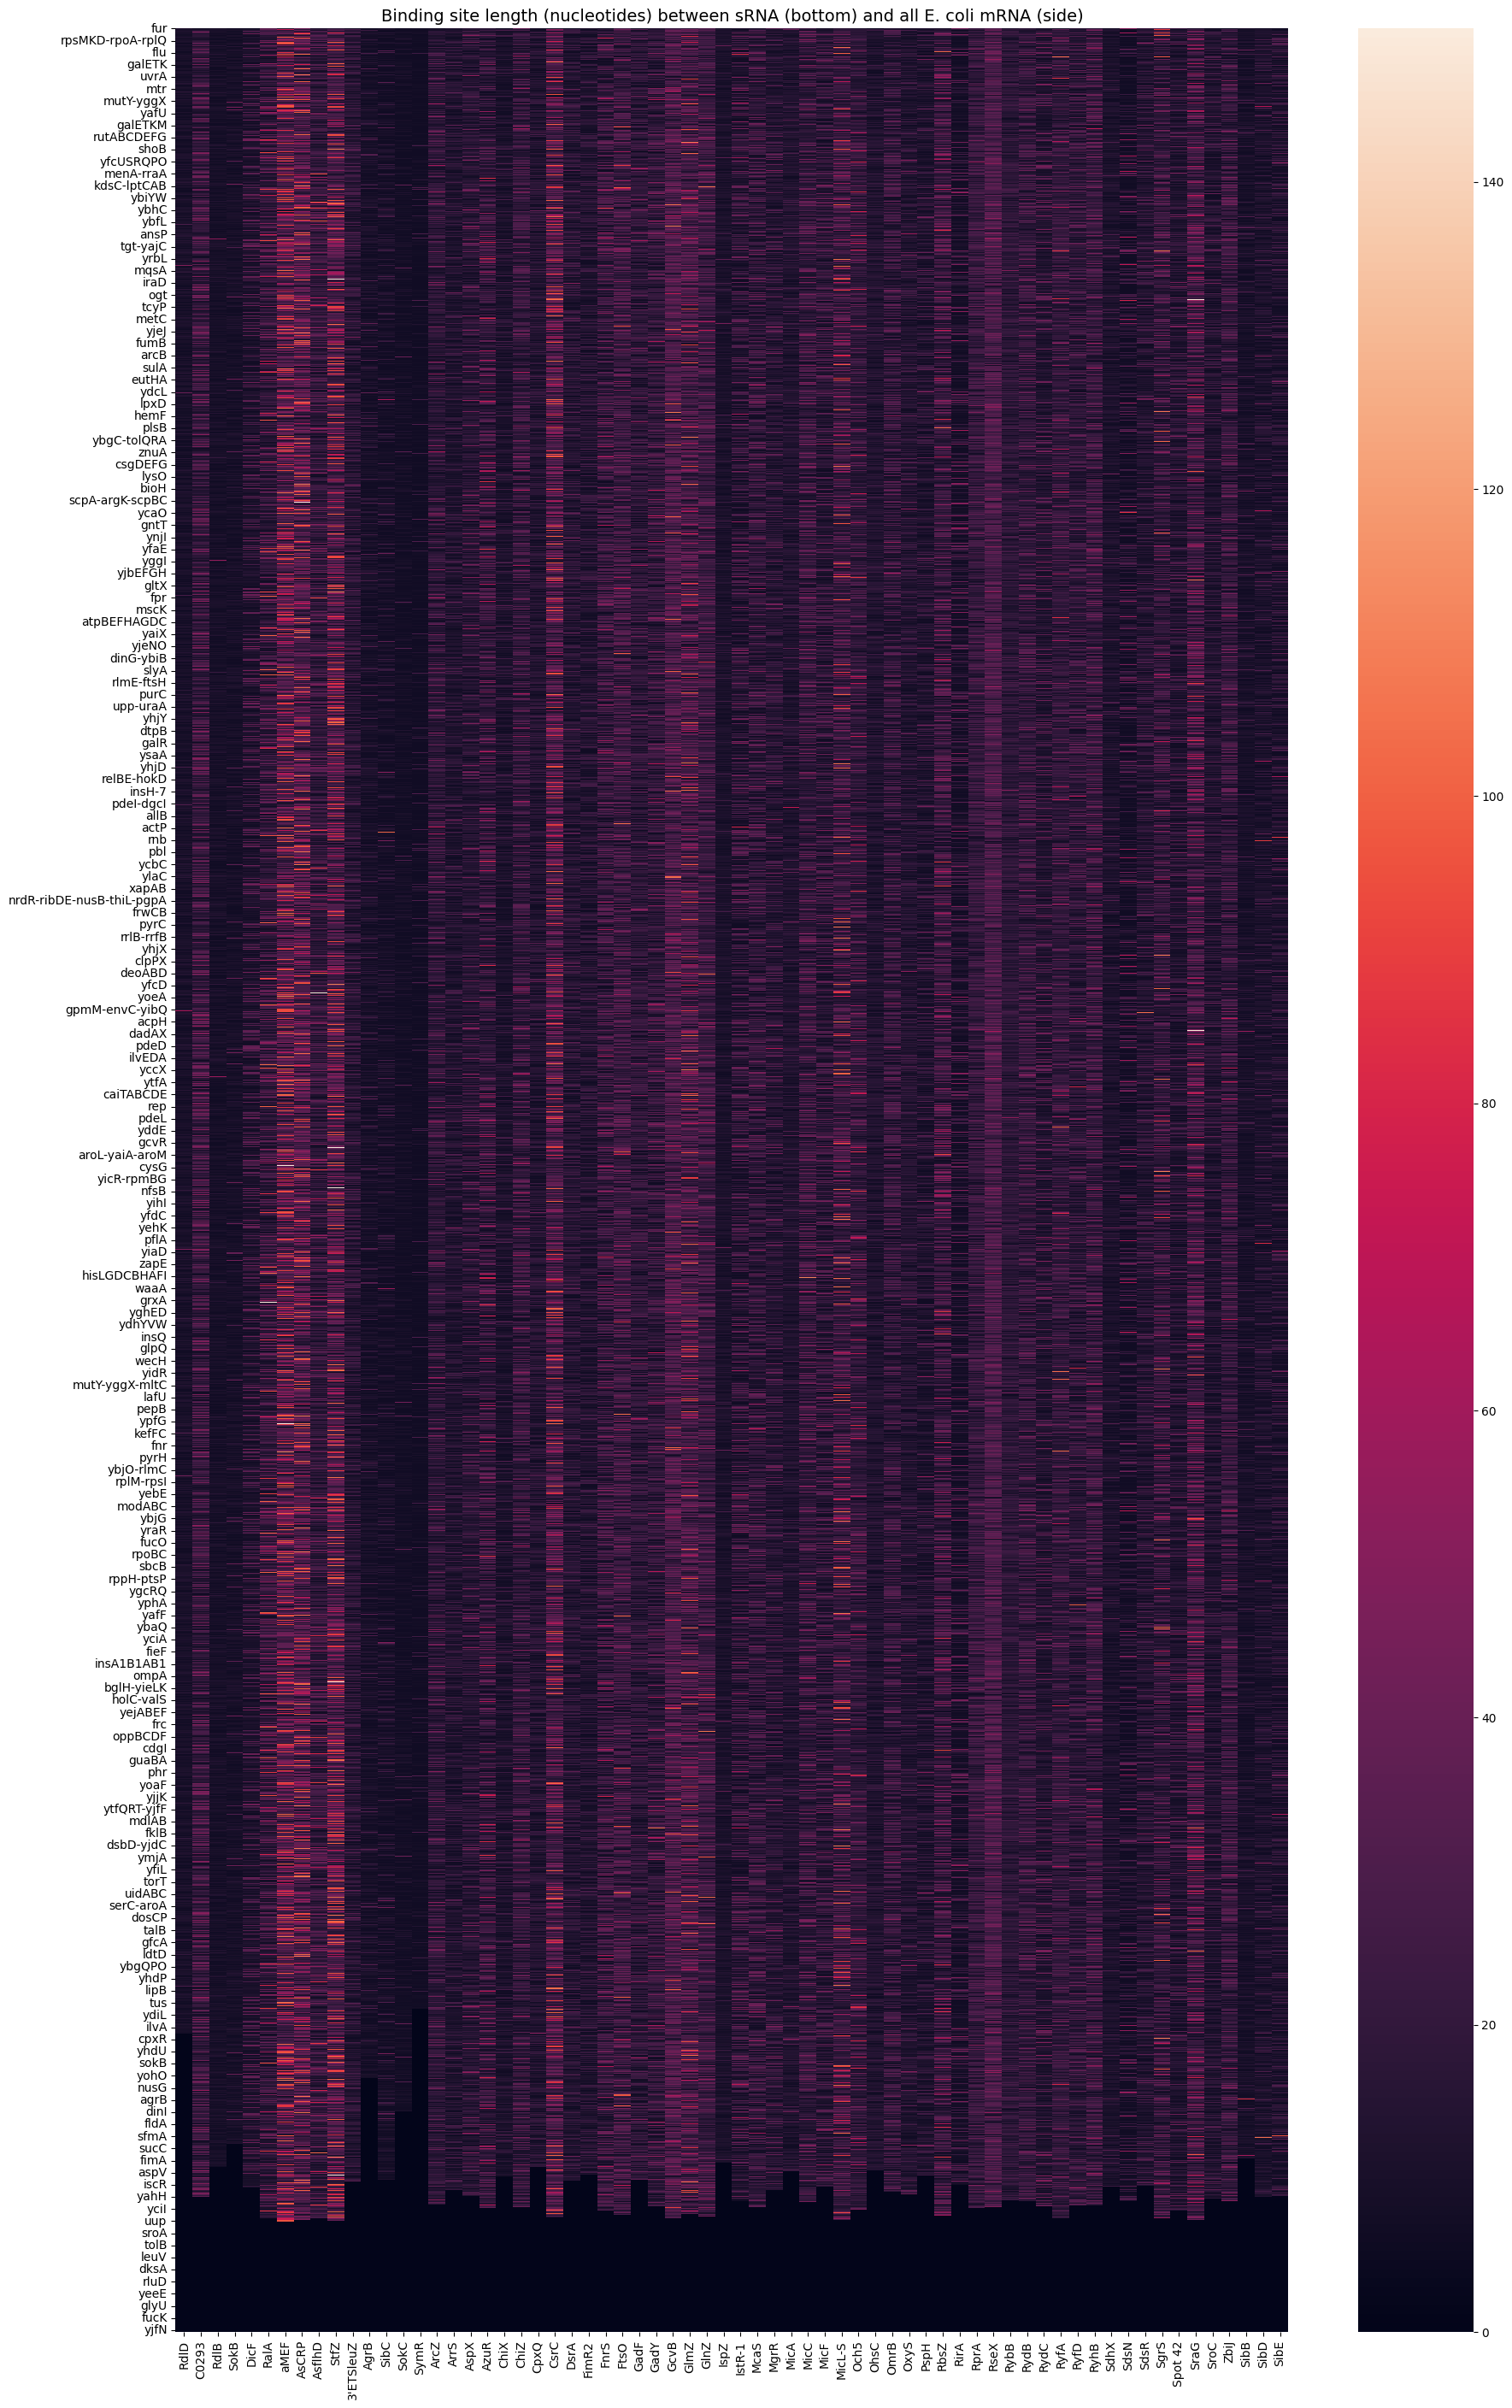

In [38]:
fig = plt.figure(figsize=(21, 35))

sns.heatmap(binding_site_total_length) # Spectral, cubehelix, vlag
plt.title('Binding site length (nucleotides) between sRNA (bottom) and all E. coli mRNA (side)', fontsize=14)

plt.savefig('data/figs/mRNA_all_bslen.jpg')


### Binding site groups

/tmp/ipykernel_3687017/1462998272.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


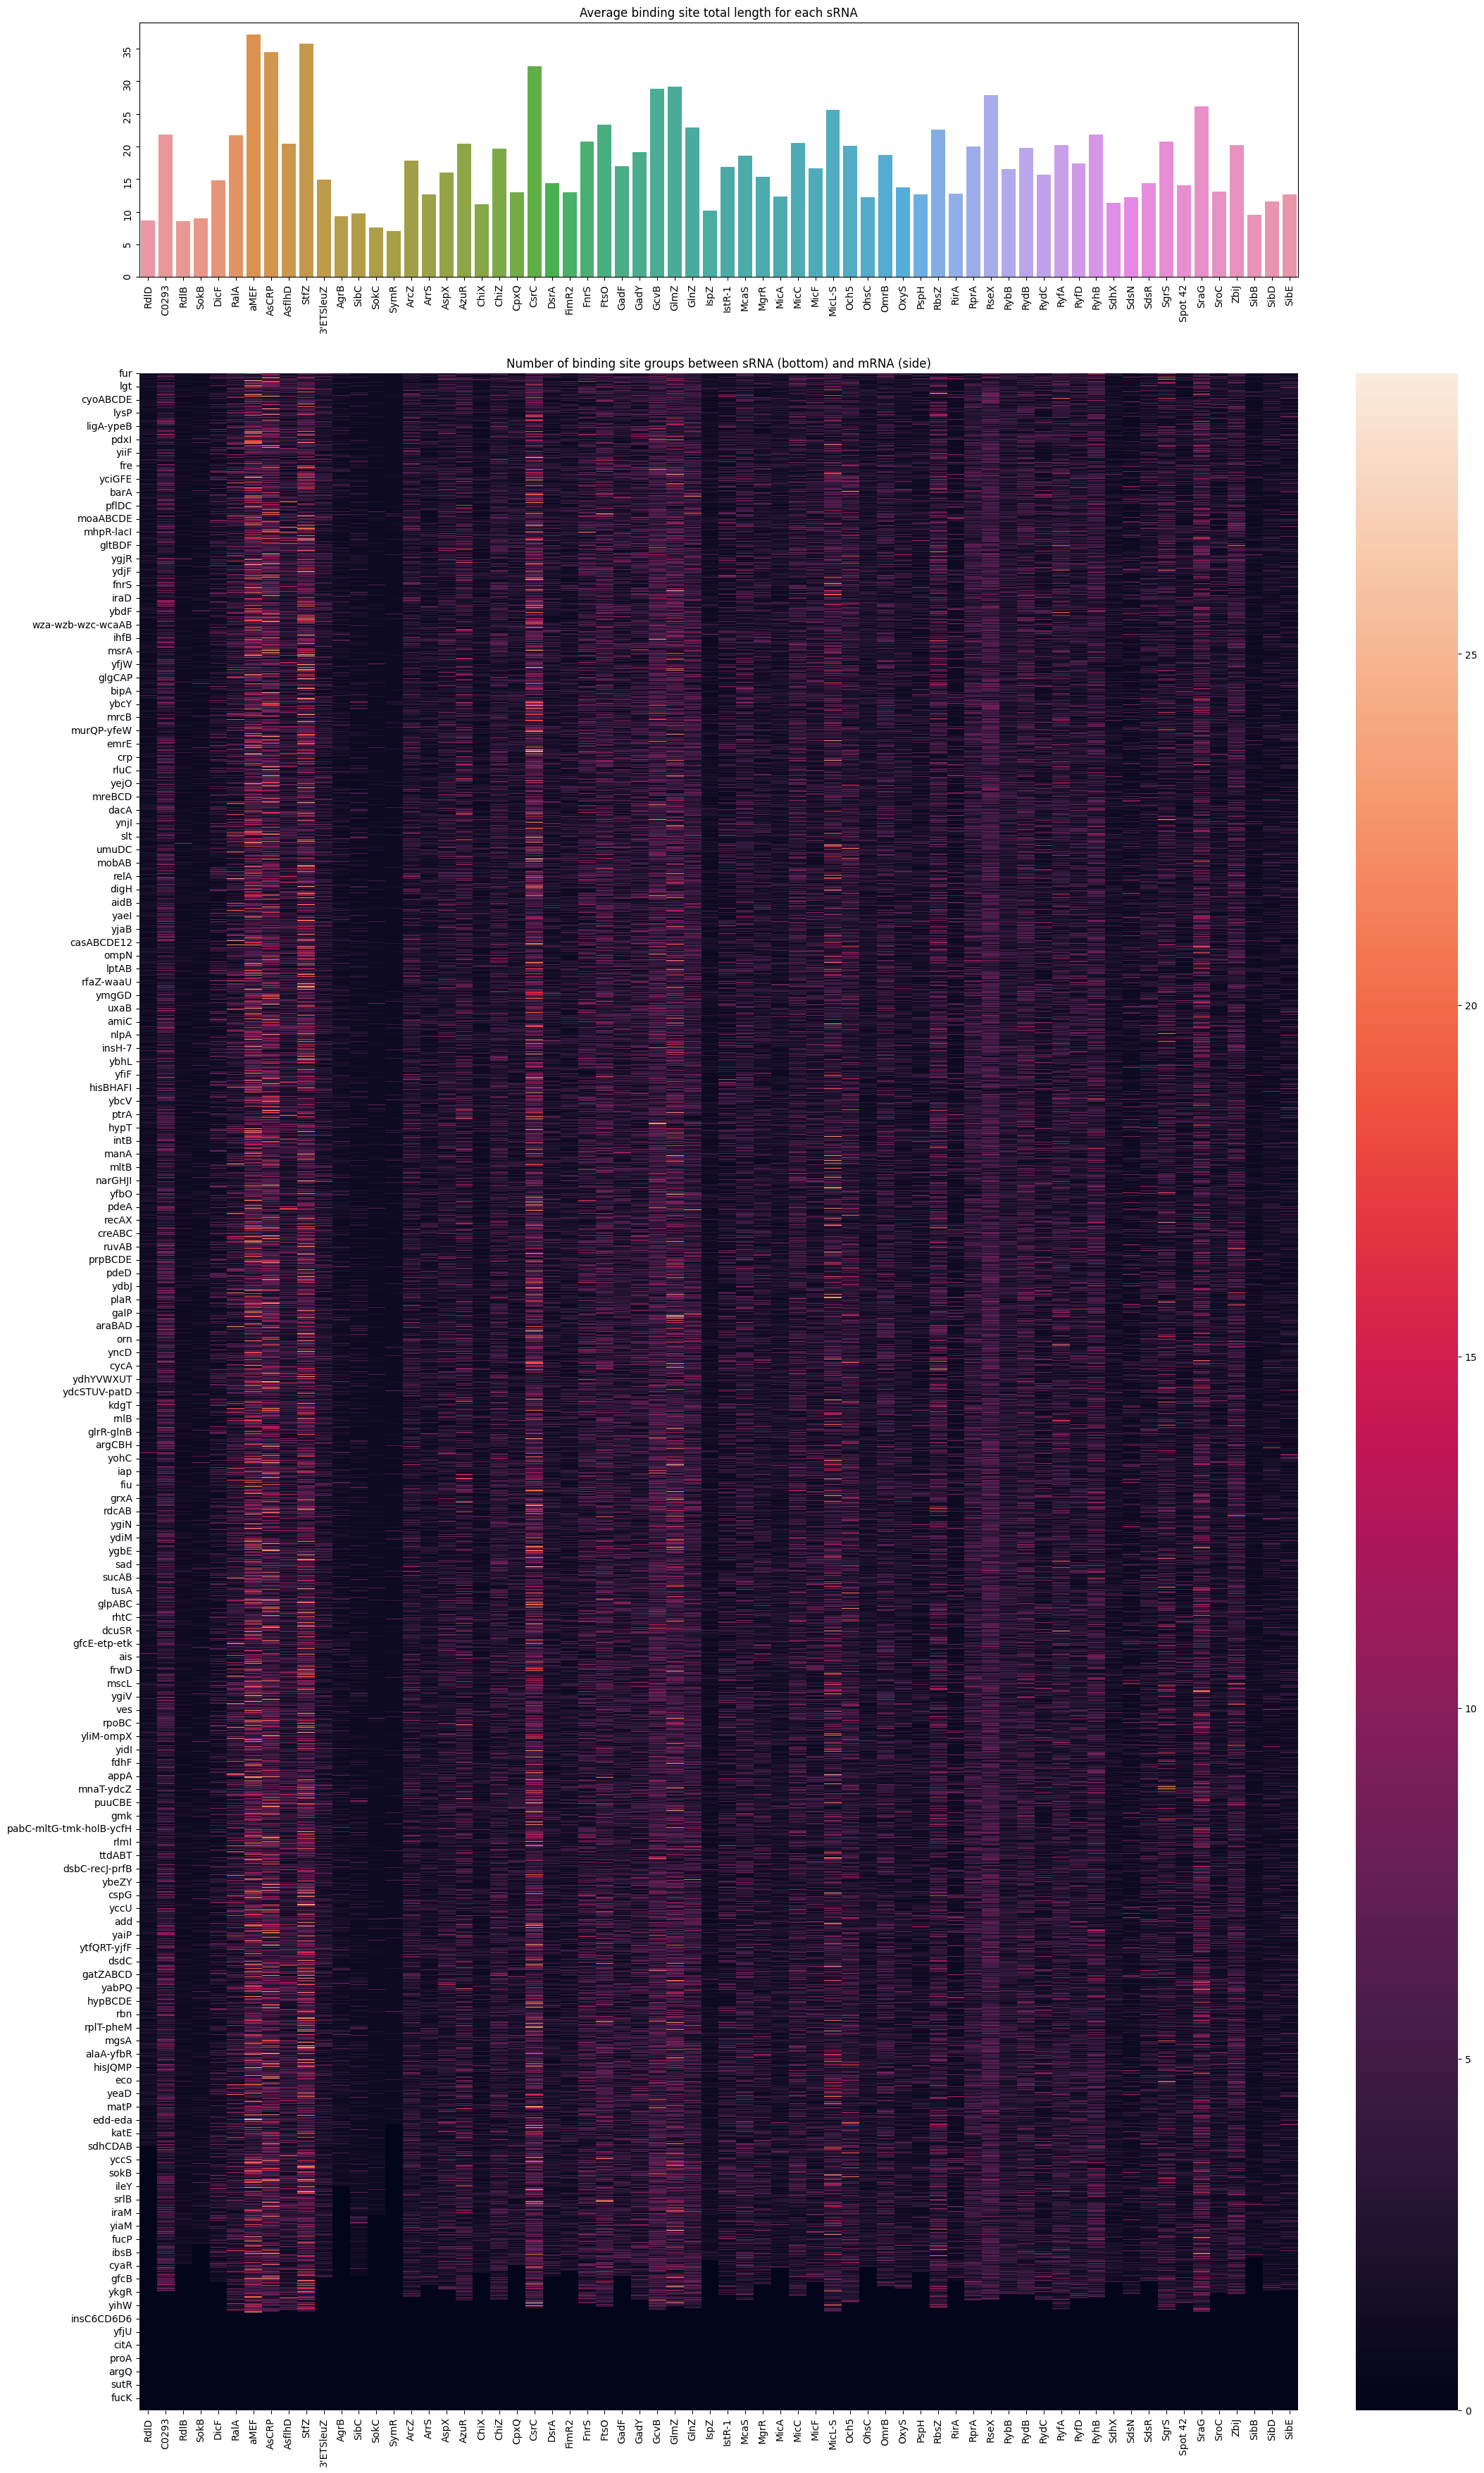

In [39]:
fig, axs = plt.subplots(2,1,figsize=(21, 35), gridspec_kw={'height_ratios': [1, 8]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

d_merged['Sequence length'] = d_merged['Sequence'].str.len()
# sns.barplot(binding_site_total_length.mean(axis=0), ax=axs[0]) #, order=[l.label1._text for l in cax.ax_heatmap.get_xaxis().majorTicks])
sns.barplot(y=binding_site_total_length.mean(axis=0).values, x=binding_site_total_length.mean(axis=0).index, ax=axs[0])
axs[0].tick_params(rotation=90)
axs[0].set_title('Average binding site total length for each sRNA')

sns.heatmap(binding_site_groups, ax=axs[1]) # Spectral, cubehelix, vlag
axs[1].set_title('Number of binding site groups between sRNA (bottom) and mRNA (side)')

plt.savefig('data/figs/mRNA_all_bsgroups.jpg')


## Visualise normalised clustermap

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2100x2700 with 0 Axes>

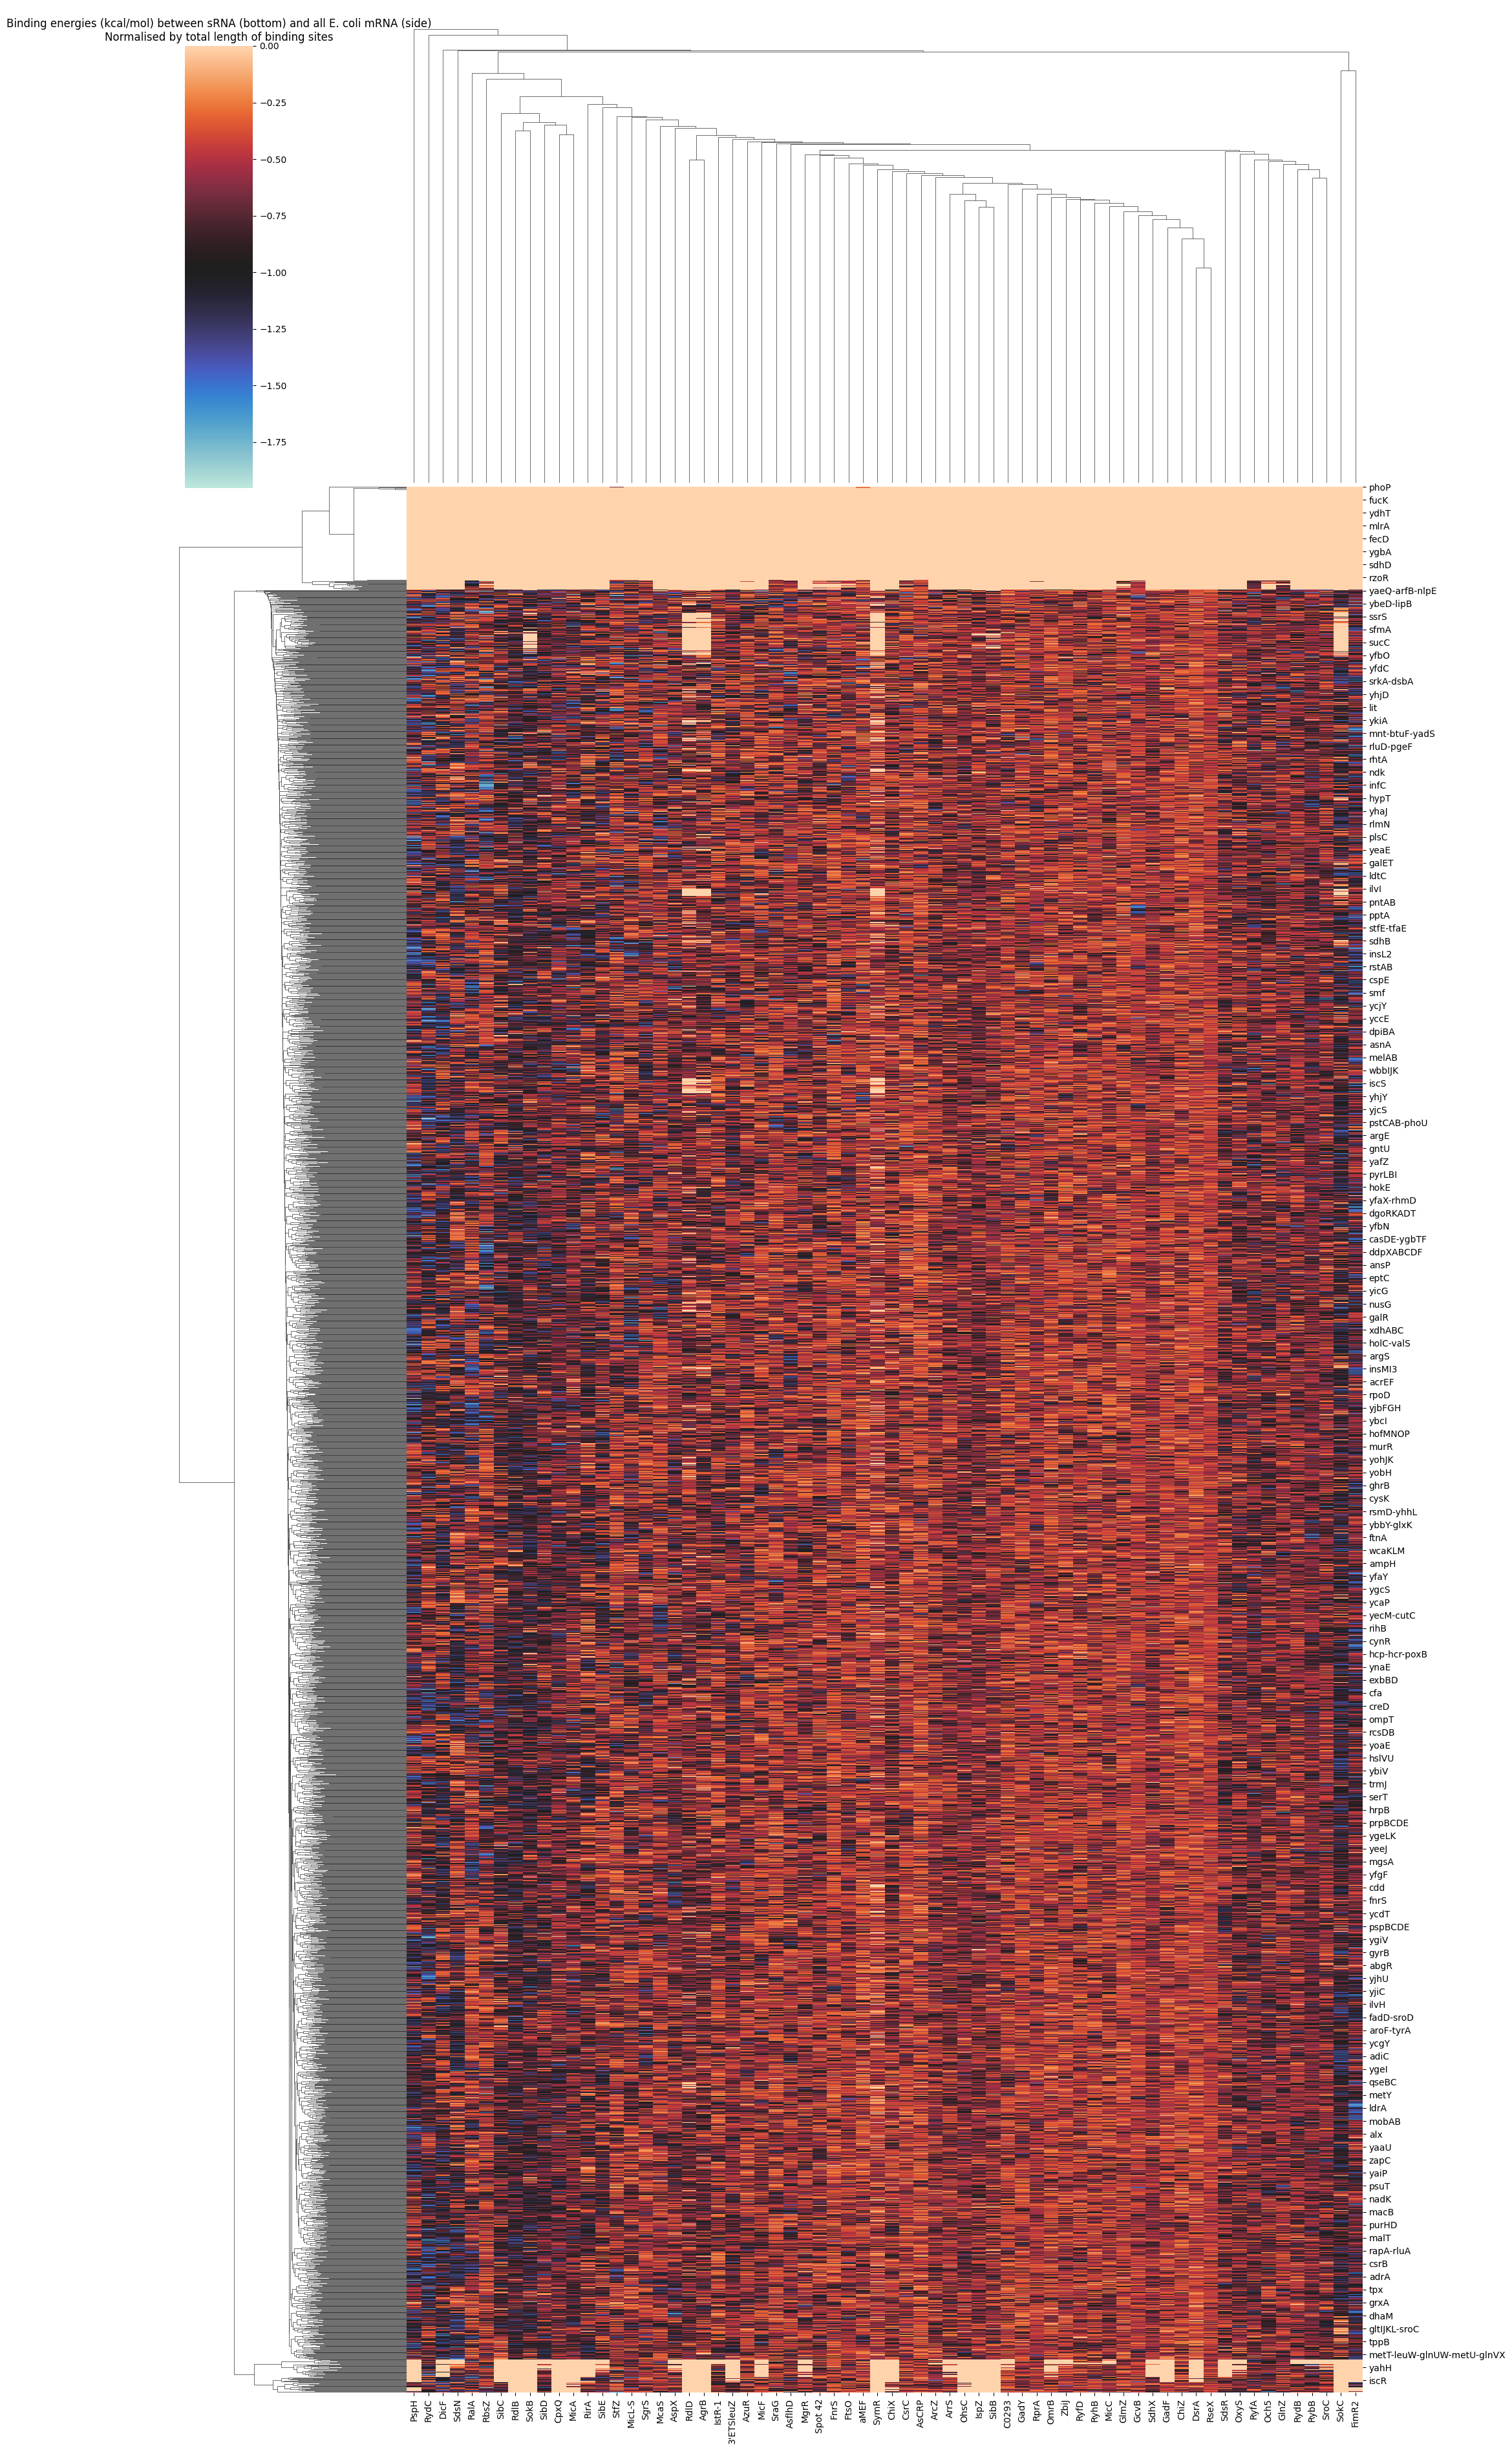

In [40]:
fig = plt.figure(figsize=(21, 27), constrained_layout=True)
cax = sns.clustermap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), figsize=(21, 38), cmap= 'icefire') # Spectral, cubehelix, vlag
# sns.heatmap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), cmap= 'icefire') # Spectral, cubehelix, vlag
plt.title('Binding energies (kcal/mol) between sRNA (bottom) and all E. coli mRNA (side)\nNormalised by total length of binding sites')

plt.savefig('data/figs/mRNA_all_energies_norm.svg')


## Visualise heatmap

/tmp/ipykernel_3687017/2464785505.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


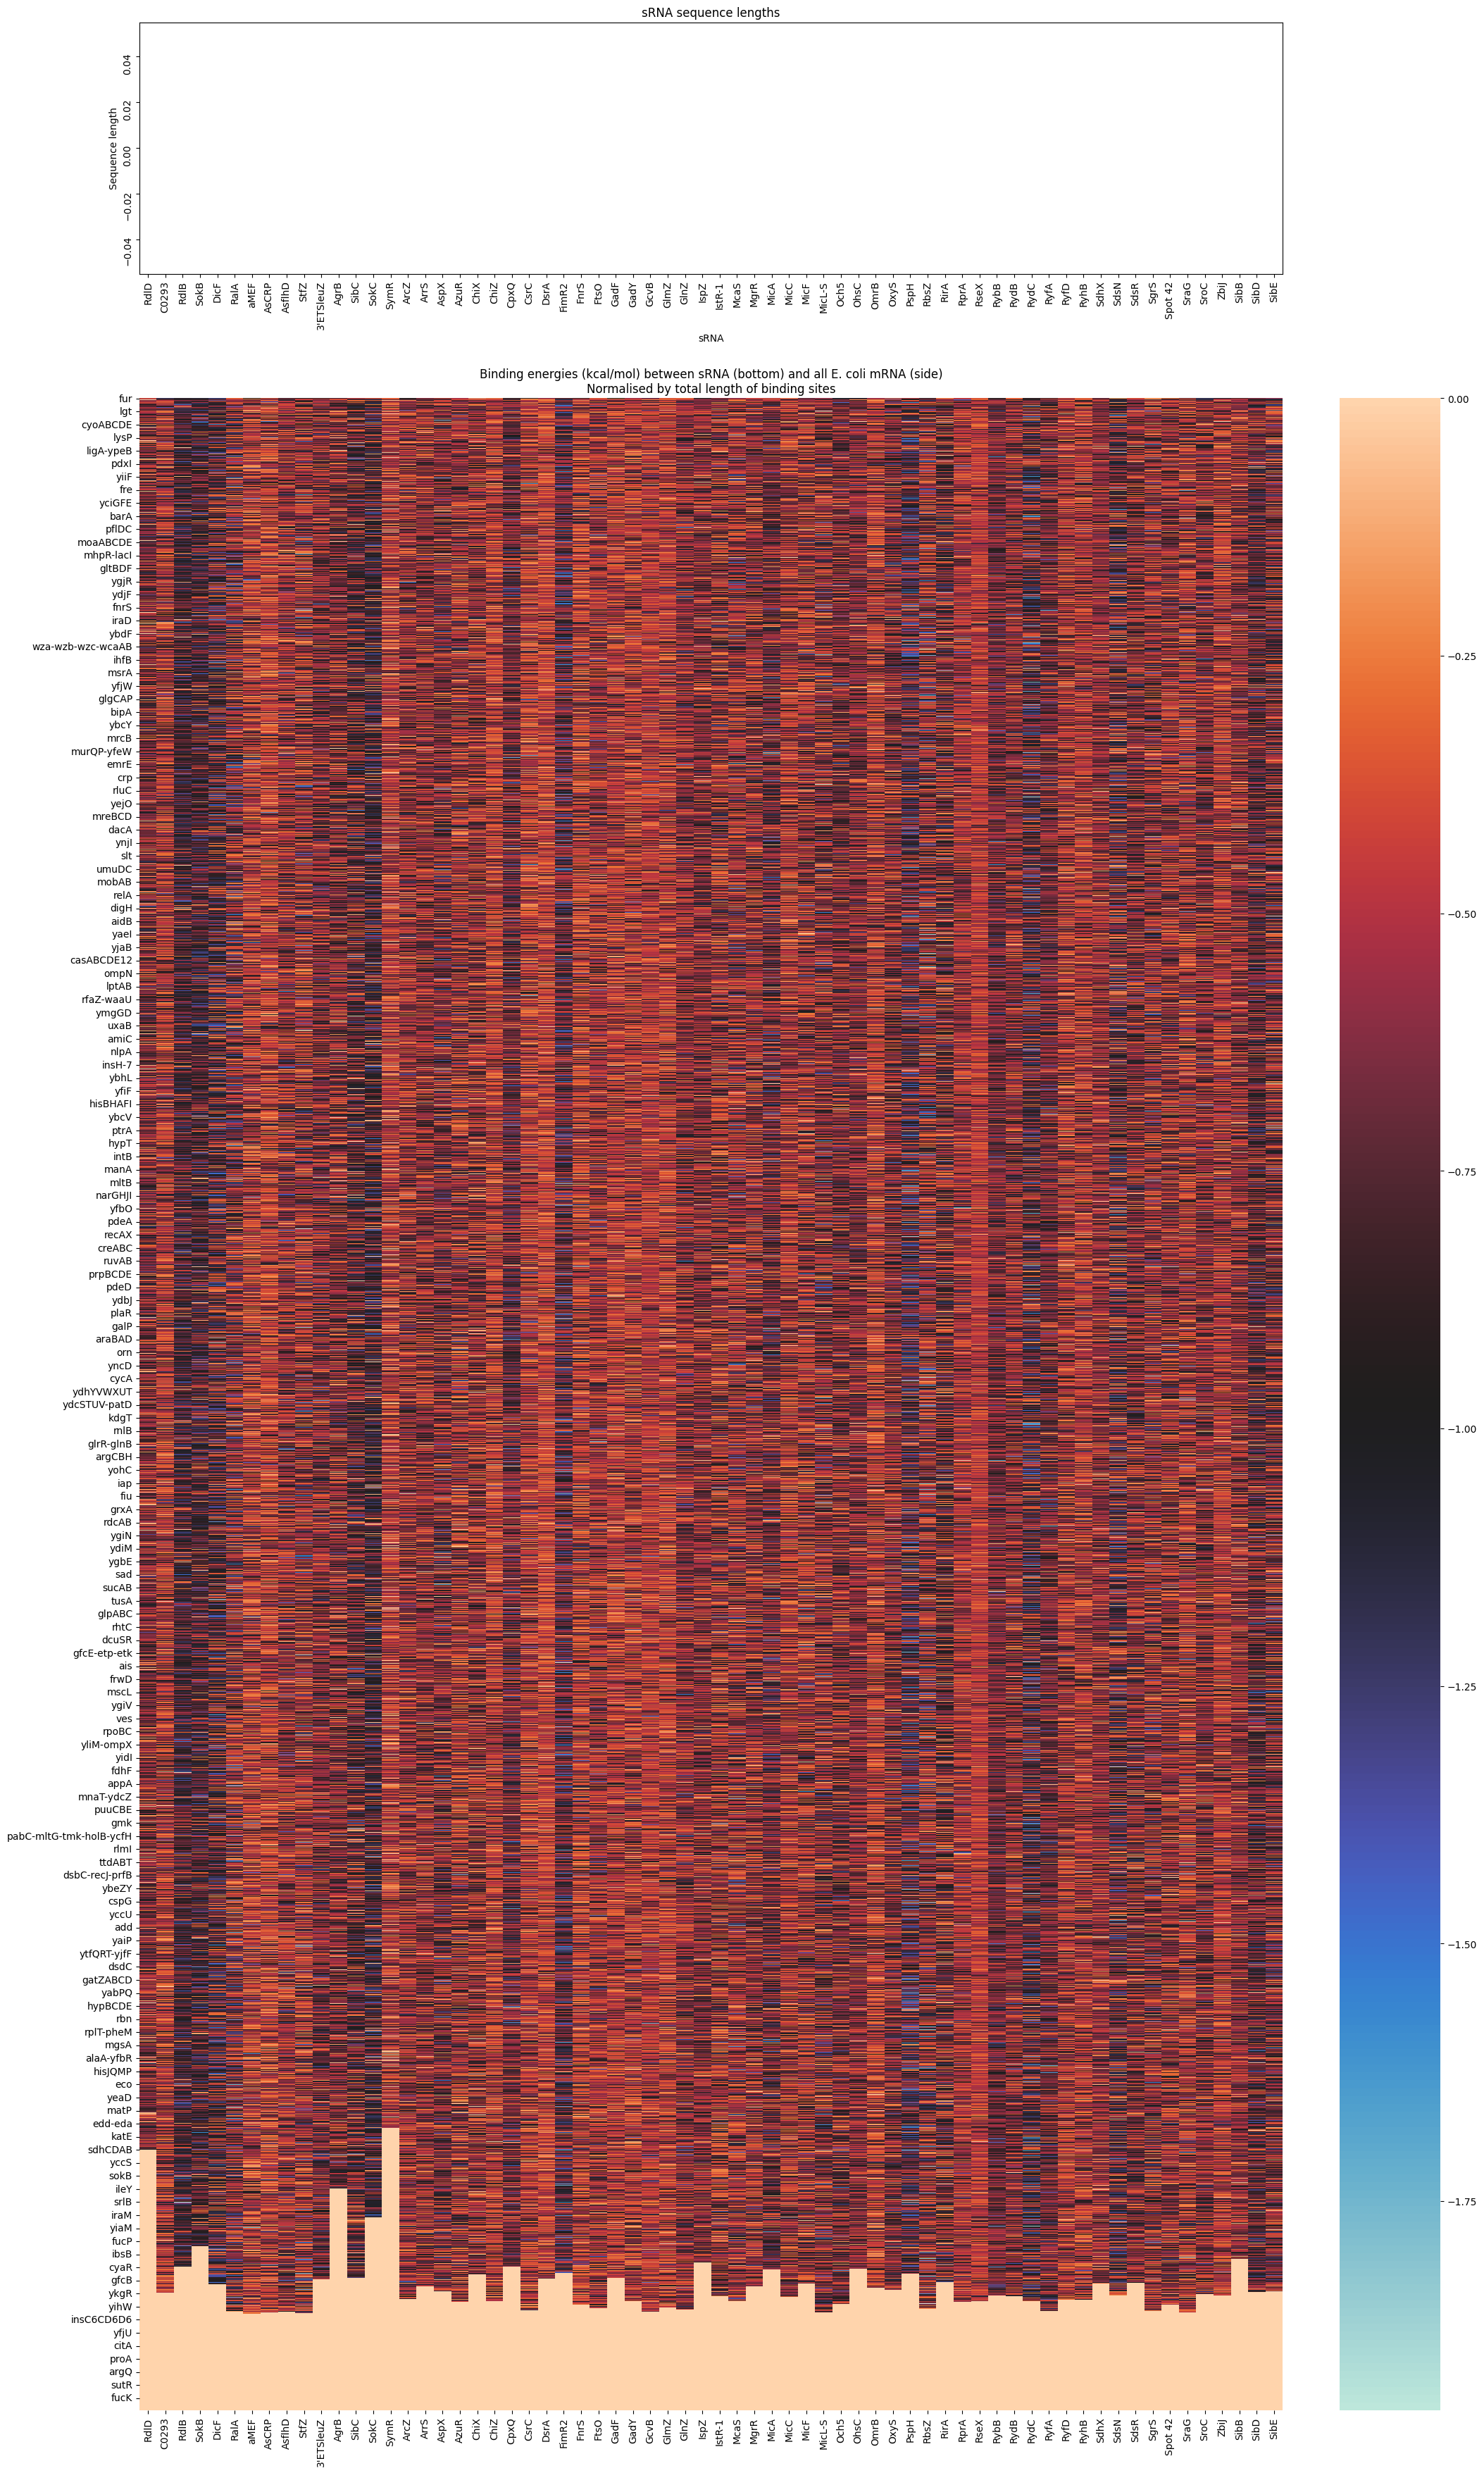

In [41]:
fig, axs = plt.subplots(2,1,figsize=(21, 35), gridspec_kw={'height_ratios': [1, 8]}, constrained_layout=True)
fig.subplots_adjust(hspace=0.5)

sns.heatmap(energies / np.where(binding_site_total_length == 0, 1, binding_site_total_length.to_numpy()), cmap= 'icefire', ax=axs[1]) # Spectral, cubehelix, vlag
axs[1].set_title('Binding energies (kcal/mol) between sRNA (bottom) and all E. coli mRNA (side)\nNormalised by total length of binding sites')

d_merged['Sequence length'] = d_merged['Sequence'].str.len()
sns.barplot(d_merged[d_merged['Category'] == 'sRNA'].rename(columns={'Name': 'sRNA'}), y='Sequence length', x='sRNA', ax=axs[0], order=[l.label1._text for l in axs[1].get_xaxis().majorTicks])
axs[0].tick_params(rotation=90)
axs[0].set_title('sRNA sequence lengths')

plt.savefig('data/figs/mRNA_all_energies_norm2.jpg')


Verify that the non-interactions really are zeros. Run the printed sequences through IntaRNA

In [42]:
s = 'antisense regulatory RNA RdlD'
m = 'sra'
print('\nmRNA: ', m, '\t', mrnas[m])
print('sRNA: ', s, '\t', srnas[s])


mRNA:  sra 	 CAACCTAATTTAGGGGTTTAGCACGTGTTTCTTCGCTACGGCGATGTTGTCCTTAAAACTAGCTACAGGATTGAGGAGTTAAAATGAAATCGAACCGTCAGGCACGTCATATTCTTGGACTGGACCATAAAATTTCTAACCAGCGCAAAATAGTTACCGAAGGTGACAAATCCAGCGTAGTAAATAACCCAACCGGCAGAAAACGCCCCGCTGAAAAGTAA
sRNA:  antisense regulatory RNA RdlD 	 GTCTAGAGTCAAGATTAGCCCCCGTGGTGTTGTCAGGTGCATACCTGCAACGTGCGGGGGTTTT


In [43]:
sim_data_l = load_json_as_dict('data/07_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json')
for s, v in sim_data_l.items():
    if len(v.values()) < len(mrnas):
        diffs = set(mrnas.keys()) - set(v.keys())
        print(s, diffs)
        break

m = list(diffs)[0]
print('\nmRNA: ', m, '\t', mrnas[m])
print('sRNA: ', s, '\t', srnas[s])

FileNotFoundError: [Errno 2] No such file or directory: 'data/07_orthogonality_mRNA_all/2023_11_12_112610/inter_data_raw.json'

They do seem to be accurate non-interactions after running a couple of them on IntaRNA :)